# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [1]:
!pip install nufeb-tools --quiet -U

In [2]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import mean_squared_error 

# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

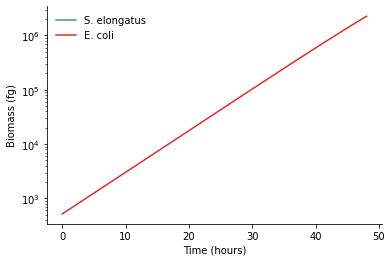

In [15]:
#Clean old simulations
#Clean old simulations
os.chdir('/home/jonathan')
os.system('nufeb-clean')
text = f'nufeb-seed --cells 0,3 --d 1e-4,1e-4,1e-4 --grid 20 --t 17300 --suc 58.4'
os.system(text)
run_nufeb = subprocess.run('/home/jonathan/NUFEB/quickrun.sh', stdout=subprocess.DEVNULL)

#Extract output
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
f, ax = plt.subplots()
plot.overall_growth(data[0].biomass,ax=ax)
plt.show()

In [56]:
df = data[0].biomass.ecw
np.prod(data[0].metadata['Dimensions'])
df = df.reset_index()
df.columns=['Hours','OD600']
df

,Hours,OD600
0,0.000000,5.184054e+02
1,0.277778,5.444924e+02
2,0.555556,5.718922e+02
3,0.833333,6.006707e+02
4,1.111111,6.308973e+02
...,...,...
169,46.944444,1.896432e+06
170,47.222222,1.982770e+06
171,47.500000,2.072339e+06
172,47.777778,2.164726e+06


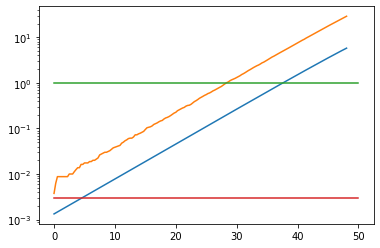

In [32]:
Volume = 1e-4*1e-4*1e-4 #m^3
mlm3 = 1e6 #mL/m^3
cellsperOD=8e8 #cells/mL @OD 1
CellNum2OD = Volume*cellsperOD*mlm3
temp = pd.concat([data[0].ntypes.ecw/CellNum2OD,data[0].ntypes.step/60/60*data[0].timestep],axis=1)
temp.columns=['OD600','Hours']
f, ax = plt.subplots()
ax.plot(data[0].biomass.ecw/1e18/(1e-12)/.39)
ax.plot(temp.Hours,temp.OD600)
ax.plot([0,50],[1,1])

ax.plot([0,50],[.003,.003])
ax.set_yscale('log')

In [12]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [17]:
def func(x):

    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = x[3]
    growthRates = {1 : 0.002,2:.163,5:.21,10:.265,20:.2996}
    exp_x = np.array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,58. , 77. , 98. ])
    exp_y = np.array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725, 0.788, 0.79 , 0.8  , 0.825, 0.83 ])
    SucroseMW = 342.3

    #Clean old simulations
    os.chdir('/home/jonathan')
    os.system('nufeb-clean')

    
    print(f'mu: {mu},ksuc: {ksuc}, m {maint}')
    # generate simulations for several initial sucrose concentrations
    for key in growthRates.keys():
        suc = key*1e3/SucroseMW

        text = f'nufeb-seed --cells 0,3 --d 1e-4,1e-4,1e-4 --grid 20 --t 17300 --suc {suc:.2f} --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint}'
        os.system(text)
    #Run simulation
    run_nufeb = subprocess.run('/home/jonathan/NUFEB/quickrun.sh', stdout=subprocess.DEVNULL)

    #Extract output
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = np.prod(data[0].metadata['Dimensions']) #m^3

    fg2kg = 1e18
    Biomass2OD = 0.36 #g-dw/L
    mlm3 = 1e6 #mL/m^3
    cellsperOD=8e8 #cells/mL @OD 1
    CellNum2OD = Volume*cellsperOD*mlm3

    dfs = []
    for x in data:
        temp = x.biomass.ecw/fg2kg/Volume/Biomass2OD
        temp = temp.reset_index()
        temp.columns=['OD600','Hours']
        temp['S0'] = x.avg_con.Sucrose[0]*SucroseMW/1e3
        dfs.append(temp)
    df = pd.concat(dfs,ignore_index=True)
    gr = growthRates.copy()
    for key in growthRates.keys():
        temp = df.loc[df.S0==key]
        try:
            popt, pcov = curve_fit(mu_func,temp.Hours, temp.OD600)
            gr.update({key :popt[1]})
        except: 
            print("fitting failed")
            gr.update({key :0})
    tmp = pd.DataFrame.from_dict(growthRates,orient='index',columns=['mu'])
    tmp2 = pd.DataFrame.from_dict(gr,orient='index',columns=['mu'])
    mu_rmse = mean_squared_error(tmp,tmp2, squared = False)
    #Compare output with experimental data
    exp = interpolate.interp1d(exp_x,exp_y)
    df20=df.loc[df.S0==20]
    sim = interpolate.interp1d(df20.Hours.to_numpy(),df20.OD600.to_numpy())
    x_range = np.arange(0,48,.1)
    rmse = mean_squared_error(exp(x_range), sim(x_range), squared = False)
    #plot
    f, ax = plt.subplots()
    ax.plot(df20.Hours,df20.OD600,label='NUFEB')
    ax.plot(exp_x,exp_y,marker='o',label='Experimental')
    ax.set_yscale('log')
    plt.show()
    return rmse + mu_rmse


In [18]:
from tqdm.notebook import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [19]:
mu_min = float('5.5e-5')
mu_max = float('1.1e-4')
rho_min = 185
rho_max = 307
k_suc_min = float('1e-1')
k_suc_max = float('1.5e1')
m_min = float('1e-9')
m_max = float('1e-7')
bounds = [(mu_min,mu_max),(rho_min,rho_max),(k_suc_min,k_suc_max),(m_min,m_max)]
n_calls = 100
gp_res = gp_minimize(func, bounds, n_calls=n_calls,n_initial_points=20,random_state=5348,verbose=True,callback=[tqdm_skopt(total=n_calls, desc="Bayesian opt")])

Bayesian opt:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
mu: 7.029995126668965e-05,ksuc: 2.3971511785065043, m 3.2186506790181813e-08


KeyboardInterrupt: 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

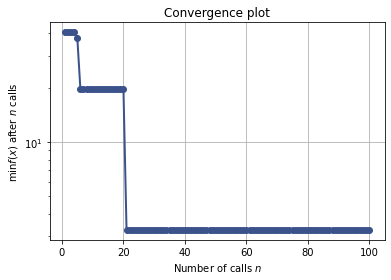

In [16]:
plot_convergence(gp_res,yscale='log')

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{2}$'>,
        <AxesSubplot:xlabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>]],
      dtype=object)

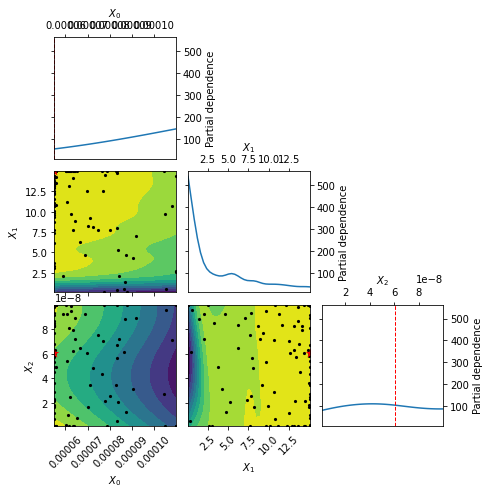

In [17]:
plot_objective(gp_res)

In [18]:
gp_res.x

[5.5e-05, 15.0, 6.047004917694896e-08]



Assigning ancestry:   0%|                                                                       | 0/173 [00:00<?, ?it/s]

Assigning ancestry:   4%|██▌                                                            | 7/173 [00:00<00:02, 63.10it/s]

Assigning ancestry:   8%|█████                                                         | 14/173 [00:00<00:02, 63.04it/s]

Assigning ancestry:  12%|███████▌                                                      | 21/173 [00:00<00:02, 63.57it/s]

Assigning ancestry:  16%|██████████                                                    | 28/173 [00:00<00:02, 63.60it/s]

Assigning ancestry:  20%|████████████▌                                                 | 35/173 [00:00<00:02, 63.38it/s]

Assigning ancestry:  24%|███████████████                                               | 42/173 [00:00<00:02, 63.86it/s]

Assigning ancestry:  28%|█████████████████▌                                            | 49/173 [00:00<00:01, 63.27it/s]

Assigning ancestry:  3

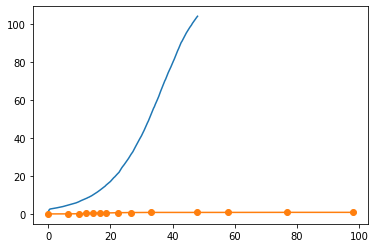

In [20]:
exp_x = np.array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,58. , 77. , 98. ])
exp_y = np.array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725, 0.788, 0.79 , 0.8  , 0.825, 0.83 ])


os.chdir('/home/jonathan')
os.system('nufeb-clean')

    #Run simulation

text = f'nufeb-seed --cells 0,100 --grid 10 --t 17300 --suc 58.4 --muecw {gp_res.x[0]}  --rhoecw 250 --ksuc {gp_res.x[1]} --maintecw {gp_res.x[2]}'
os.system(text)
run_nufeb = subprocess.run('/home/jonathan/NUFEB/quickrun.sh', stdout=subprocess.DEVNULL)
os.chdir('/home/jonathan')
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-5 #m^3
mlm3 = 1e6 #mL/m^3
cellsperOD=8e8 #cells/mL @OD 1
CellNum2OD = Volume*cellsperOD*mlm3

df = pd.concat([data[0].ntypes.ecw/CellNum2OD,data[0].ntypes.step/60/60*data[0].timestep],axis=1)
df.columns=['OD600','Hours']
f, ax = plt.subplots()
ax.plot(df.Hours,df.OD600,label='NUFEB')
ax.plot(exp_x,exp_y,marker='o',label='Experimental')
plt.show()